<a href="https://colab.research.google.com/github/mrinmoykundu/Bengali-AI_Grapheme_Project/blob/master/Bengali_AI_(Updated)(MyCopy).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Accessing the data from cloud
Press Ctrl+Shift+i and then click on console and type:

function ClickConnect(){
console.log("Working"); 
document.querySelector("colab-toolbar-button#connect").click() 
}
setInterval(ClickConnect,60000)

to prevent the runtime from disconnecting. (Not sure if it works though)


Drive Data :https://drive.google.com/open?id=1SVLfASfRpJZ5HwU5IyVXVVWLsxvbLiP6

## Downloading Data from Kaggle (For reference only)
Use Google Drive to access data for Bengali AI, as shown below

In [0]:
#!mkdir ~/.kaggle
#After this, upload your kaggle token


In [0]:
#!cp kaggle.json ~/.kaggle/
#!chmod 600 ~/.kaggle/kaggle.json
#!kaggle competitions download -c bengaliai-cv19

##Google Drive Data accessing (Recommended process)

In [0]:
# For accessing Google Drive via Colab
from google.colab import drive
drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Importing library

In [0]:
import numpy as np 
import pandas as pd
import PIL.Image as Image, PIL.ImageDraw as ImageDraw, PIL.ImageFont as ImageFont

import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [0]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import torchvision

# Loading data

## Loading train_df, test_df and class_map_df

In [0]:
train_df_ = pd.read_csv('/content/gdrive/My Drive/Bengali_AI_data/train.csv')
test_df_ = pd.read_csv('/content/gdrive/My Drive/Bengali_AI_data/test.csv')
class_map_df = pd.read_csv('/content/gdrive/My Drive/Bengali_AI_data/class_map.csv')
sample_sub_df = pd.read_csv('/content/gdrive/My Drive/Bengali_AI_data/sample_submission.csv')

In [0]:
train_df_.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো


In [0]:
test_df_.head()

In [0]:
sample_sub_df.head()

In [0]:
class_map_df.head()

In [0]:
print(f'Size of training data: {train_df_.shape}')
print(f'Size of test data: {test_df_.shape}')
print(f'Size of class map: {class_map_df.shape}')

Size of training data: (200840, 5)
Size of test data: (36, 3)
Size of class map: (186, 3)


In [0]:
#from zipfile import ZipFile

In [0]:
#with ZipFile('/content/gdrive/My Drive/Bengali_AI_data/train_image_data_0.parquet.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
  # zipObj.extractall()
  # print('Done')

## Loading image data from drive

In [0]:
TRAIN = ['/content/gdrive/My Drive/Bengali_AI_data/train_image_data_0.parquet',
         '/content/gdrive/My Drive/Bengali_AI_data/train_image_data_1.parquet',
         '/content/gdrive/My Drive/Bengali_AI_data/train_image_data_2.parquet',
         '/content/gdrive/My Drive/Bengali_AI_data/train_image_data_3.parquet']

data0=pd.read_parquet(TRAIN[0])
for i in range(1): #4 for all files
  data  = pd.concat([data0,pd.read_parquet(TRAIN[i+1])],ignore_index=True)


del data0
#data1=pd.read_parquet('/content/gdrive/My Drive/Bengali_AI_data/train_image_data_1.parquet')
#data2=pd.read_parquet('/content/gdrive/My Drive/Bengali_AI_data/train_image_data_2.parquet')
#data3=pd.read_parquet('/content/gdrive/My Drive/Bengali_AI_data/train_image_data_3.parquet')
#requires 1:54 s

#Prepossing the data

In [0]:
n_epoch = 3
batch_size_train = 64
batch_size_test = 1000

learning_rate = 0.01
momentum = 0.5
log_interval = 100

random_seed = 1

torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [0]:
HEIGHT = 137
WIDTH = 236
SIZE = 128

#sample_data0 = data0.loc[0:50]
#sample_images0 = data0.iloc[0:50, 1:].values.reshape(-1, HEIGHT, WIDTH)
train_dataset_images = data.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH).astype(np.uint8)

## Image Resizing, croping and train_dataset_images0 preparation

In [0]:
# https://www.kaggle.com/iafoss/image-preprocessing-128x128
import cv2
def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_resize(img0, size=SIZE, pad=16):
    #crop a box around pixels large than the threshold 
    #some images contain line at the sides
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > 80)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < 28] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return cv2.resize(img,(size,size))

In [0]:
n_imgs = 2
fig, axs = plt.subplots(n_imgs, 2, figsize=(10, 5*n_imgs))

for idx in range(n_imgs):
    #somehow the original input is inverted
    img0 = 255 - data.iloc[idx, 1:].values.reshape(HEIGHT, WIDTH).astype(np.uint8)
    #normalize each image by its max val
    img = (img0*(255.0/img0.max())).astype(np.uint8)
    img = crop_resize(img)

    axs[idx,0].imshow(img0)
    axs[idx,0].set_title('Original image')
    axs[idx,0].axis('off')
    axs[idx,1].imshow(img)
    axs[idx,1].set_title('Crop & resize')
    axs[idx,1].axis('off')
plt.show()
img

In [0]:
type(train_dataset_images0)
len(data0)

50210

In [0]:
#import tdqm

x_tot,x2_tot = [],[]

#for fname in TRAIN[0]:
#df = pd.read_parquet(fname)
#the input is inverted
df = data #We are dealng with data0 is only, for time being


train_dataset_images = 255 - train_dataset_images
resized_train_dataset_images = np.zeros((len(df),SIZE,SIZE)).astype(np.uint8)

for idx in range(len(df)):
  #name = df.iloc[idx,0]
  #normalize each image by its max val
  img = (train_dataset_images[idx]*(255.0/train_dataset_images[idx].max())).astype(np.uint8)
  img = crop_resize(img)
  resized_train_dataset_images[idx] = img
        
  x_tot.append((img/255.0).mean())
  x2_tot.append(((img/255.0)**2).mean())
  #img = cv2.imencode('.png',img)[1]
  #img_out.writestr(name + '.png', img)

del df

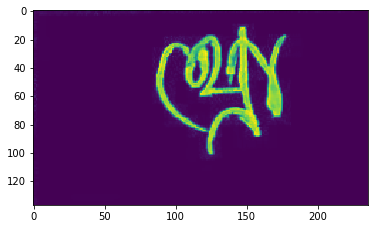

In [0]:
plt.imshow(train_dataset_images[4])

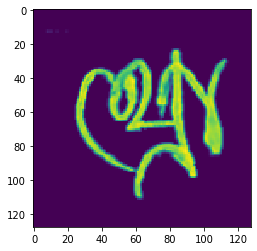

In [0]:
plt.imshow(resized_train_dataset_images[4])

In [0]:
#image stats
img_mean =  np.array(x_tot).mean()
img_std =  np.sqrt(np.array(x2_tot).mean() - img_mean**2)
print('mean:',img_mean, ', std:', img_std)

mean: 0.06927922005352107 , std: 0.20523578194555483


In [0]:
train_dataset_images = resized_train_dataset_images
del resized_train_dataset_images

## target_dataset_images0 preparation

In [0]:
#plt.imshow(train_dataset_images0[1], cmap = 'gray')
train_dataset_images[1][60]

In [0]:
#sample_train_df = train_df_.iloc[0:50,1:4]
#sample_train_df.head()
#index = 2
#sample_train_df['grapheme_root'][index], sample_train_df['vowel_diacritic'][index],sample_train_df['consonant_diacritic'][index]

target_dataset_image = train_df_.iloc[0:len(train_dataset_images),1:4]
target_dataset_image.head()

In [0]:
#Transformation object

data_transforms = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize( (img_mean,),(img_std,) )
        ])

# GraphemeDataset Class

In [0]:
#sample_data = sample_data0.merge(sample_train_df, on="image_id", how = 'inner')
#sample_data.head()

class GraphemeDataset(Dataset):
    def __init__(self, images, targets, transfrom):
        self.images = images
        self.target_grapheme_root = targets['grapheme_root']
        self.target_vowel_diacritic = targets['vowel_diacritic']
        self.target_consonant_diacritic = targets['consonant_diacritic']

        self.transform = transfrom

    def __getitem__(self, index):
        image = self.images[index]
        target = [self.target_grapheme_root[index], self.target_vowel_diacritic[index],self.target_consonant_diacritic[index] ]

        y = torch.tensor(target)
        
        #Applying threshold here
        image[image < 127] = 0
        image[image >= 127] = 255

        #x = torchvision.transforms.functional.to_tensor(image)
        if self.transform:
            x = self.transform(image)

        return x,y

    def __len__(self):
        return len(self.images)

# Loading data into Dataloader

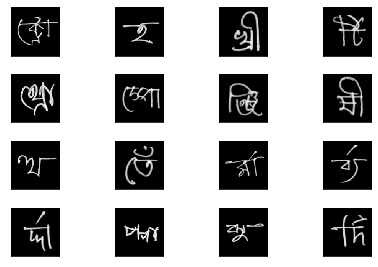

In [0]:
# showing some original(resized and cropped, not transformed) images from train_dataset_images0
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.tight_layout()
    plt.imshow(train_dataset_images[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])

In [0]:
images_loader = torch.utils.data.DataLoader(
    GraphemeDataset(train_dataset_images, target_dataset_image, data_transforms),
    batch_size=batch_size_test, 
    shuffle=True
    )  
images_loader

NameError: ignored

In [0]:
examples = enumerate(images0_loader)
 
batch_idx, (example_data, example_targets) = next(examples)

In [0]:
example_targets.shape

len(GraphemeDataset(train_dataset_images0, target_dataset_image0, data_transforms))

def Extract(lst,n): 
    return torch.tensor(list(list(zip(*lst))[n])) 

#Extract(example_targets,0).size()

example_data

In [0]:
#showing some transformed images from images0_loader
for i in range(2):
  plt.subplot(2,1,i+1)
  #plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='binary', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

## Sample train , test split

In [0]:
sample_data = GraphemeDataset(train_dataset_images0, target_dataset_image0, data_transforms)

l = len(sample_data)
train_set, test_set = torch.utils.data.random_split(sample_data, [int(l*0.7), l - int(l*0.7)])

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size_train, 
    shuffle=True,
    drop_last=True
    ) 

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size_test, 
    shuffle=True,
    drop_last=True
    )   

print(int(l*0.7))
print(l - int(l*0.7))

35147
15063


In [0]:

examples = enumerate(test_loader)

batch_idx, (example_data, example_targets) = next(examples)

example_data.mean()

tensor(0.0278)

# MNIST Net

In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
    self.conv3 = nn.Conv2d(20, 15, kernel_size=5)

    self.conv2_drop = nn.Dropout2d()

    last_layer_size = 60 #for 128*128 images

    self.fc1_root = nn.Linear(last_layer_size,200)
    self.fc2_root = nn.Linear(200,168) #grapheme roots 168

    self.fc1_vowel = nn.Linear(last_layer_size,50)
    self.fc2_vowel = nn.Linear(50,11) #vowel_diacritic 11

    self.fc1_consonant = nn.Linear(last_layer_size,50)
    self.fc2_consonant = nn.Linear(50,7) #consonent_diacritic 7

  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x), 3))
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 3))
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv3(x)), 3))

    x = x.view(x.size(0), -1) #flatting the 2D image data
    #print(x.shape)

    x_root = F.relu(self.fc1_root(x))
    x_root = F.dropout(x_root, training=self.training)
    x_root = self.fc2_root(x_root)

    x_vowel = F.relu(self.fc1_vowel(x))
    x_vowel = F.dropout(x_vowel, training=self.training)
    x_vowel = self.fc2_vowel(x_vowel)

    x_consonent = F.relu(self.fc1_consonant(x))
    x_consonent = F.dropout(x_consonent, training=self.training)
    x_consonent = self.fc2_consonant(x_consonent)

    return F.log_softmax(x_root),  F.log_softmax(x_vowel),  F.log_softmax(x_vowel)

# AlexNet

In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
class AlexNet(nn.Module):

    def __init__(self, num_classes=2):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier1 = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, 168)
        )
        self.classifier2 = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, 11)
        )
        self.classifier3 = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, 7)

        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x1 = self.classifier1(x)
        x2 = self.classifier2(x)
        x3 = self.classifier3(x)
        return F.log_softmax(x1),  F.log_softmax(x2),  F.log_softmax(x3)

# Training

In [0]:
network = Net().to('cuda') #Creating an instance of the Net class model
#network = ResNet18().to('cuda')
#network = AlexNet().to('cuda')

optimizer = optim.SGD(network.parameters(), lr = learning_rate,
                      momentum=momentum) #Chosing SGD as an optimizer

#Some variables to keep track of the learning process
#To later create a learning curve

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epoch + 1)]

len(test_loader.dataset)


def train(epoch): #epoch just indicating in which epoch the train function is running
  
  network.train() #Setting the model in training mode

  for batch_idx, (data, target) in enumerate(train_loader):
    #The whole process from here is done on batch basis
    #batch_idx is the batch index
    #data is a batch_len*1*128*128 tensor of a batch of data
    #target is a batch_len*10 tensor of the data's labels

   data, target = data.to('cuda'), target.to('cuda') #This line to be run if data and target are not compatible in tensor form

   #These 5 lines are routine code for training a model in pytorch, so far
   optimizer.zero_grad()
   output1, output2, output3 = network(data)
   loss1 = F.nll_loss(output1, Extract(target,0).to('cuda')) #We can choose different loss function, but nll_loss or negative log-likelihodd loss is widely used
   loss2 = F.nll_loss(output2, Extract(target,1).to('cuda'))
   loss3 = F.nll_loss(output3, Extract(target,2).to('cuda'))

   loss = loss1 + loss2 + loss3

   loss.backward() #This the auto-grad step, the particular useful characteristic of pytorch, 
                   #accumulatation of gradients in forward propagation makes this to happen 
   optimizer.step()

   #Tracker and visualization
   if batch_idx % log_interval == 0:
     print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss : {:.6f}'.format(
         epoch, batch_idx * len(data), len(train_loader.dataset),
         100.* batch_idx / len(train_loader), loss.item()))
    
     train_losses.append(loss.item())

     train_counter.append(
         (batch_idx*64) + (epoch-1)*len(train_loader.dataset))
     
     torch.save(network.state_dict(), '/content/model.pth')

     torch.save(optimizer.state_dict(), '/content/optimizer.pth')


def test():
  network.eval() #Setting the model in evaluation/testing mode
  test_loss = 0
  correct = 0

  with torch.no_grad(): #no_grad is activated, since for testing we don't need further gradient accumulation
    for batch_idx, (data, target) in enumerate(test_loader):

      #The whole process from here is done on batch basis
      #batch_idx is the batch index
      #data is a batch_len*1*28*28 tensor of a batch of data
      #target is a batch_len*10 tensor of the data's labels

      data, target = data.to('cuda'), target.to('cuda') #This line to be run if data and target are not compatible in tensor form

      output1, output2, output3 = network(data)
      #print(data.size())
      #print(output1.size())
      test_loss1 = F.nll_loss(output1, Extract(target,0).to('cuda'), size_average=False).item() #negative log-likelihodd loss
      test_loss2 = F.nll_loss(output2, Extract(target,1).to('cuda'), size_average=False).item()
      test_loss3 = F.nll_loss(output3, Extract(target,2).to('cuda'), size_average=False).item()
      test_loss += test_loss1 + test_loss2 + test_loss2

      pred1 = output1.data.max(1, keepdim=True)[1] #Picking the maximum probable result
      pred2 = output2.data.max(1, keepdim=True)[1]
      pred3 = output3.data.max(1, keepdim=True)[1]

      temp = Extract(target,0).to('cuda')
      correct1 = pred1.eq(temp.data.view_as(pred1)).sum()

      temp = Extract(target,1).to('cuda')
      correct2 = pred2.eq(temp.data.view_as(pred2)).sum()

      temp = Extract(target,2).to('cuda')
      correct3 = pred3.eq(temp.data.view_as(pred3)).sum()

      #correct += correct1 + correct2 + correct3


  #Tracker and visualization
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)

  print('\nTest set: Avg. loss: {:.4f}, Accuracy1: {}/{} ({:.0f}%)\n Accuracy2: {}/{} ({:.0f}%)\n Accuracy3: {}/{} ({:.0f}%)\n'.format(
      test_loss, correct1, len(test_loader.dataset),
      100. * correct1/ len(test_loader.dataset),

      correct2, len(test_loader.dataset),
      100. * correct2/ len(test_loader.dataset),
      
      correct3, len(test_loader.dataset),
      100. * correct3/ len(test_loader.dataset) )
      )

In [0]:
test()

for epoch in range(1, n_epoch+1):
  train(epoch)
  test()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning:

Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning:

size_average and reduce args will be deprecated, please use reduction='sum' instead.




Test set: Avg. loss: 9.8808, Accuracy1: 5/15063 (0%)
 Accuracy2: 106/15063 (1%)
 Accuracy3: 3/15063 (0%)

Train Epoch: 1 [0/35147 (0%)]	Loss : 10.048380
Train Epoch: 1 [6400/35147 (18%)]	Loss : 8.877086
Train Epoch: 1 [12800/35147 (36%)]	Loss : 8.768079
Train Epoch: 1 [19200/35147 (55%)]	Loss : 8.716417
Train Epoch: 1 [25600/35147 (73%)]	Loss : 8.427016
Train Epoch: 1 [32000/35147 (91%)]	Loss : 8.920237

Test set: Avg. loss: 8.8298, Accuracy1: 34/15063 (0%)
 Accuracy2: 205/15063 (1%)
 Accuracy3: 639/15063 (4%)

Train Epoch: 2 [0/35147 (0%)]	Loss : 8.534582
Train Epoch: 2 [6400/35147 (18%)]	Loss : 8.352588
Train Epoch: 2 [12800/35147 (36%)]	Loss : 8.391491
Train Epoch: 2 [19200/35147 (55%)]	Loss : 7.976336
Train Epoch: 2 [25600/35147 (73%)]	Loss : 8.113303
Train Epoch: 2 [32000/35147 (91%)]	Loss : 8.371104

Test set: Avg. loss: 8.3757, Accuracy1: 46/15063 (0%)
 Accuracy2: 231/15063 (2%)
 Accuracy3: 610/15063 (4%)

Train Epoch: 3 [0/35147 (0%)]	Loss : 8.048846
Train Epoch: 3 [6400/35147

In [0]:
torch.cuda.is_available()
!nvcc --version

Text(0, 0.5, 'negative log likelihood loss')

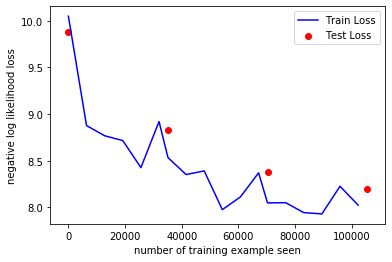

In [0]:
 fig = plt.figure()

plt.plot(train_counter, train_losses, color = 'blue')

plt.scatter(test_counter, test_losses, color ='red')
plt.legend(['Train Loss', 'Test Loss'], loc = 'upper right')
plt.xlabel('number of training example seen')
plt.ylabel('negative log likelihood loss')

In [0]:
#train = pd.read_csv('/content/gdrive/My Drive/Bengali_AI_data/train.csv')

In [0]:
#data_full = pd.concat([data0,data1,data2,data3],ignore_index=True)

In [0]:
#del data1,data2,data3
#releases around 6gb of memory from RAM

In [0]:
# This was a test to see how long loading feather data takes
#data0 = pd.read_feather('/content/gdrive/My Drive/Bengali_AI_data/train_image_data_0.feather')
#data1 = pd.read_feather('/content/gdrive/My Drive/Bengali_AI_data/train_image_data_1.feather')
#data2 = pd.read_feather('/content/gdrive/My Drive/Bengali_AI_data/train_image_data_2.feather')
#data3 = pd.read_feather('/content/gdrive/My Drive/Bengali_AI_data/train_image_data_3.feather')
# Took 2:30s  :(

# Test implementation of a notebook (Bishmoy)

https://www.kaggle.com/hanjoonchoe/grapheme-resnet-18-n-l-inference-lb-0-8566/data implemented down here. This uses pretrained weights ('saved_weights.pth' included in the drive)

In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms,models
from tqdm import tqdm_notebook as tqdm

In [0]:
test = pd.read_csv('/content/gdrive/My Drive/Bengali_AI_data/test.csv')

In [0]:
class ResidualBlock(nn.Module):
    def __init__(self,in_channels,out_channels,stride=1,kernel_size=3,padding=1,bias=False):
        super(ResidualBlock,self).__init__()
        self.cnn1 =nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True)
        )
        self.cnn2 = nn.Sequential(
            nn.Conv2d(out_channels,out_channels,kernel_size,1,padding,bias=False),
            nn.BatchNorm2d(out_channels)
        )
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=stride,bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Sequential()
            
    def forward(self,x):
        residual = x
        x = self.cnn1(x)
        x = self.cnn2(x)
        x += self.shortcut(residual)
        x = nn.ReLU(True)(x)
        return x

In [0]:
class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18,self).__init__()
        
        self.block1 = nn.Sequential(
            nn.Conv2d(1,64,kernel_size=2,stride=2,padding=3,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True)
        )
        
        self.block2 = nn.Sequential(
            nn.MaxPool2d(1,1),
            ResidualBlock(64,64),
            ResidualBlock(64,64,2)
        )
        
        self.block3 = nn.Sequential(
            ResidualBlock(64,128),
            ResidualBlock(128,128,2)
        )
        
        self.block4 = nn.Sequential(
            ResidualBlock(128,256),
            ResidualBlock(256,256,2)
        )
        self.block5 = nn.Sequential(
            ResidualBlock(256,512),
            ResidualBlock(512,512,2)
        )
        
        self.avgpool = nn.AvgPool2d(2)
        # vowel_diacritic
        self.fc1 = nn.Linear(512,11)
        # grapheme_root
        self.fc2 = nn.Linear(512,168)
        # consonant_diacritic
        self.fc3 = nn.Linear(512,7)
        
    def forward(self,x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.avgpool(x)
        x = x.view(x.size(0),-1)
        x1 = self.fc1(x)
        x2 = self.fc2(x)
        x3 = self.fc3(x)
        return x1,x2,x3

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ResNet18().to(device)
model.load_state_dict(torch.load('/content/gdrive/My Drive/Bengali_AI_data/saved_weights.pth'))

<All keys matched successfully>

In [0]:
def Resize(df,size=64):
    resized = {} 
    df = df.set_index('image_id')
    for i in tqdm(range(df.shape[0])):
        image = cv2.resize(df.loc[df.index[i]].values.reshape(137,236),(size,size))
        resized[df.index[i]] = image.reshape(-1)
    resized = pd.DataFrame(resized).T.reset_index()
    resized.columns = resized.columns.astype(str)
    resized.rename(columns={'index':'image_id'},inplace=True)
    return resized

In [0]:
model.eval()
test_data = ['test_image_data_0.parquet','test_image_data_1.parquet','test_image_data_2.parquet','test_image_data_3.parquet']
predictions = []
batch_size=1
for fname in test_data:
    data = pd.read_parquet(f'/content/gdrive/My Drive/Bengali_AI_data/{fname}')
    data = Resize(data)
    test_image = GraphemeDataset(data)
    test_loader = torch.utils.data.DataLoader(test_image,batch_size=1,shuffle=False)
    with torch.no_grad():
        for idx, (inputs) in tqdm(enumerate(test_loader),total=len(test_loader)):
            inputs.to(device)
            
            outputs1,outputs2,outputs3 = model(inputs.unsqueeze(1).float().cuda())
            predictions.append(outputs3.argmax(1).cpu().detach().numpy())
            predictions.append(outputs2.argmax(1).cpu().detach().numpy())
            predictions.append(outputs1.argmax(1).cpu().detach().numpy())

In [0]:
submission = pd.read_csv('/content/gdrive/My Drive/Bengali_AI_data/sample_submission.csv')

In [0]:
submission.target = np.hstack(predictions)

In [0]:
submission.head(10) ## A good way to understand our expected output.

,row_id,target
0,Test_0_consonant_diacritic,0
1,Test_0_grapheme_root,3
2,Test_0_vowel_diacritic,0
3,Test_1_consonant_diacritic,0
4,Test_1_grapheme_root,93
5,Test_1_vowel_diacritic,2
6,Test_2_consonant_diacritic,0
7,Test_2_grapheme_root,19
8,Test_2_vowel_diacritic,0
9,Test_3_consonant_diacritic,0
